# Lineare Regression (Übung)

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Prediction-Ex.ipynb)

$$
\begin{align*}
\text{Nachfrage}_{t} & = \beta_0 + \beta_1 t + e_t, \quad t = 1, 2, \ldots, T \\
\end{align*}
$$

$$
\begin{align*}
\text{Nachfrage}_{t} = 40 + 1.5 t + e_t, \quad t = 1, 2, \ldots, T \\
\end{align*}
$$

Um die Notation einfach zu halten, schreiben wir $y_t$ für die Nachfrage. Das Modell ist also

$$
\begin{align*}
y_t & = 40 + 1.5 t + e_t, \quad t = 1, 2, \ldots, T \\
\end{align*}
$$

Wir werden im Folgenden 10 Beobachtungen generieren, also $T=10$.

In [1]:
%pip install gurobipy

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate some example data

periods = 10

dt = pd.DataFrame({
        "time": np.arange(periods) + 1,
        "noise": np.random.randn(periods) * 2
    })

dt["y"] = 40 + 1.5 * dt["time"] + dt["noise"]
dt

/home/amarov/stats/opt2026-de/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


,time,noise,y
0,1,3.528105,45.028105
1,2,0.800314,43.800314
2,3,1.957476,46.457476
3,4,4.481786,50.481786
4,5,3.735116,51.235116
5,6,-1.954556,47.045444
6,7,1.900177,52.400177
7,8,-0.302714,51.697286
8,9,-0.206438,53.293562
9,10,0.821197,55.821197


Es ist sehr hilfreich, die Daten zu visualisieren. Hier verwenden wir die Bibliothek `matplotlib`. Details zu `matplotlib` finden Sie in der [Dokumentation](https://matplotlib.org/stable/tutorials/pyplot.html).


Text(0, 0.5, 'Backsteine')

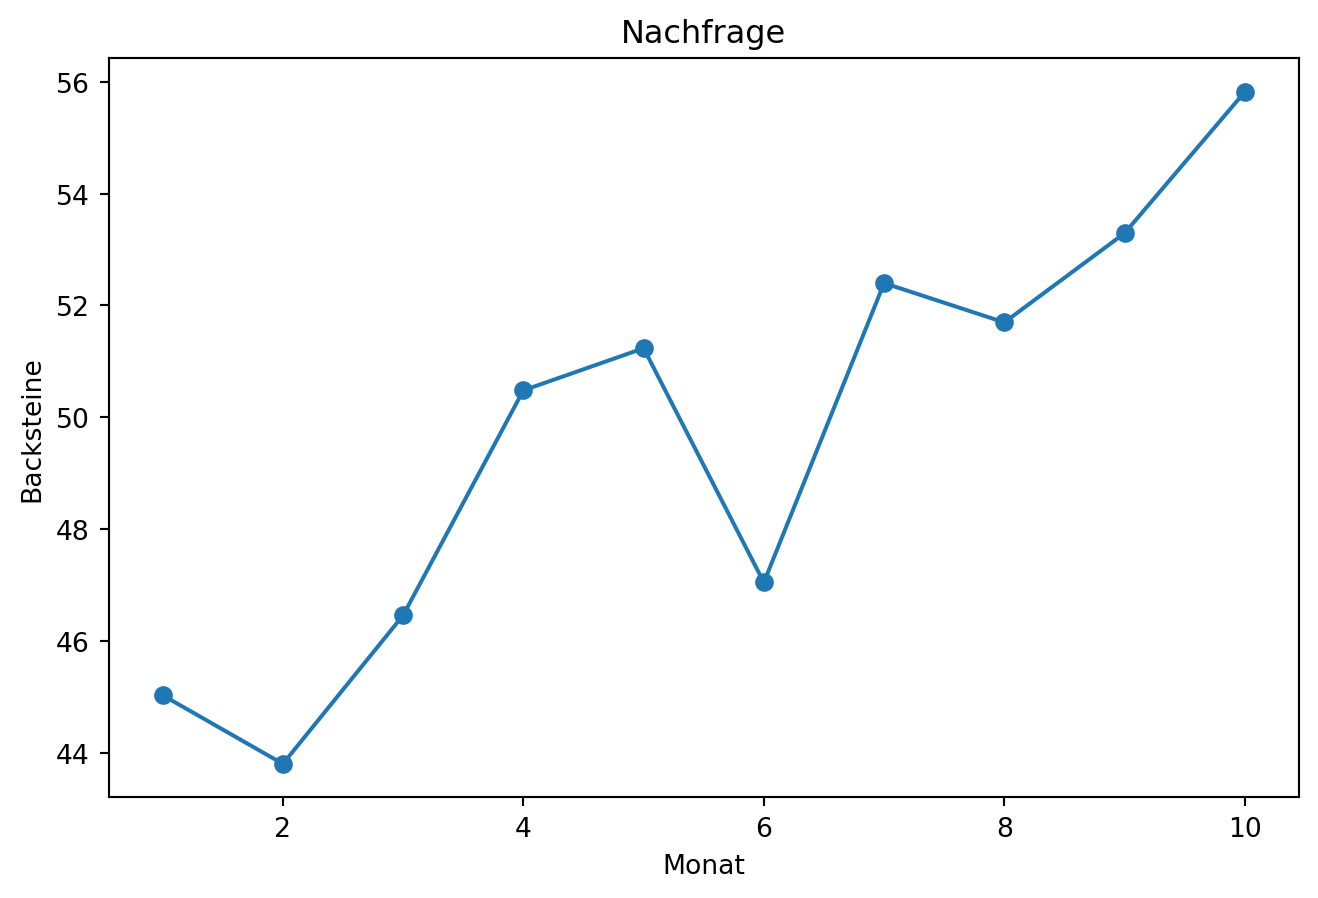

In [2]:
# Plot the data

plt.figure(figsize=(8, 5))
plt.plot(dt["time"], dt["y"], 'o-', label='Data')
plt.title('Nachfrage')
plt.xlabel('Monat')
plt.ylabel('Backsteine')

Versuchen wir zuerst, die Nachfrage für die beobachteten Monate mit der Gleichung

$$
\hat{y} = 39 + 0.8 t
$$

zu schätzen und die Abweichungen zwischen den beobachteten und den geschätzten Werten (Residuen) zu berechnen.

$$
r_t = y_{t} - \hat{y}_t
$$

In [3]:
# Berechnen Sie die Residuen für die ersten zwei Monate
# Lesen Sie einfach die Daten aus dem Datensatz per Hand ab



In [4]:
# # Berechnen Sie die Schätzungen für alle  Monate 
# # Berechnen Sie auch die Residuen für alle Monate (vergleichen Sie das Ergebnis mit den per Hand berechneten Residuen)

# dt["y_predicted_naive"] = ...
# dt["residuals_naive"] = ...


In [5]:
# # Plot the data and the trend line

# fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# axes[0].plot(dt["time"], dt["y"], 'o-', label='Data')
# axes[0].plot(dt["time"], dt["y_predicted_naive"], 'r-', label='Trend Line')
# axes[0].set_title('Nachfrage')
# axes[0].set_xlabel('Monat')

# # Plot the residuals

# axes[1].plot(dt["time"], dt["residuals_naive"], 'o-', label='Residuals')
# axes[1].axhline(0, color='r', linestyle='--')
# axes[1].set_title('Residuen')
# axes[1].set_xlabel('Monat')
# axes[1].set_ylabel('Residuen')


## Kleinste Quadrate

Die Methode der kleinsten Quadrate minimiert die Summe der quadrierten Residuen:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
\end{align*}
$$

Text(0.5, 1.0, '$\\hat{y} = \\beta_0$')

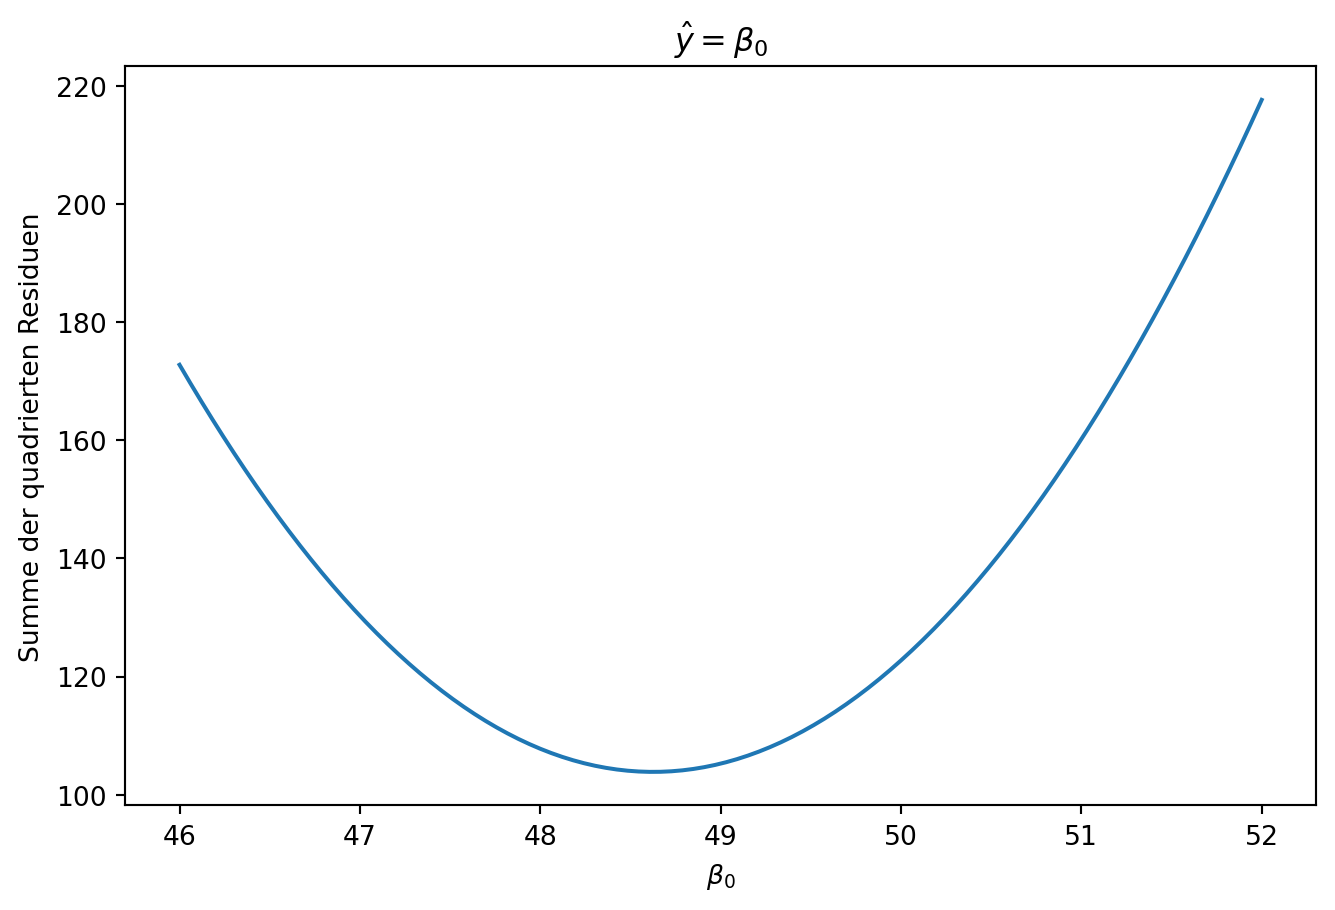

In [6]:
# Visualize the residual sum of squares for a range of beta_0 values

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted
    
# Calculate the residual sum of squares
rss = np.sum(residuals**2, axis=1)

# Plot the residual sum of squares

plt.figure(figsize=(8, 5))
plt.plot(beta_0_values, rss)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der quadrierten Residuen')
plt.title(r"$\hat{y} = \beta_0$")

Text(0.5, 0.92, '$\\hat{y} = \\beta_0 + \\beta_1 t$')

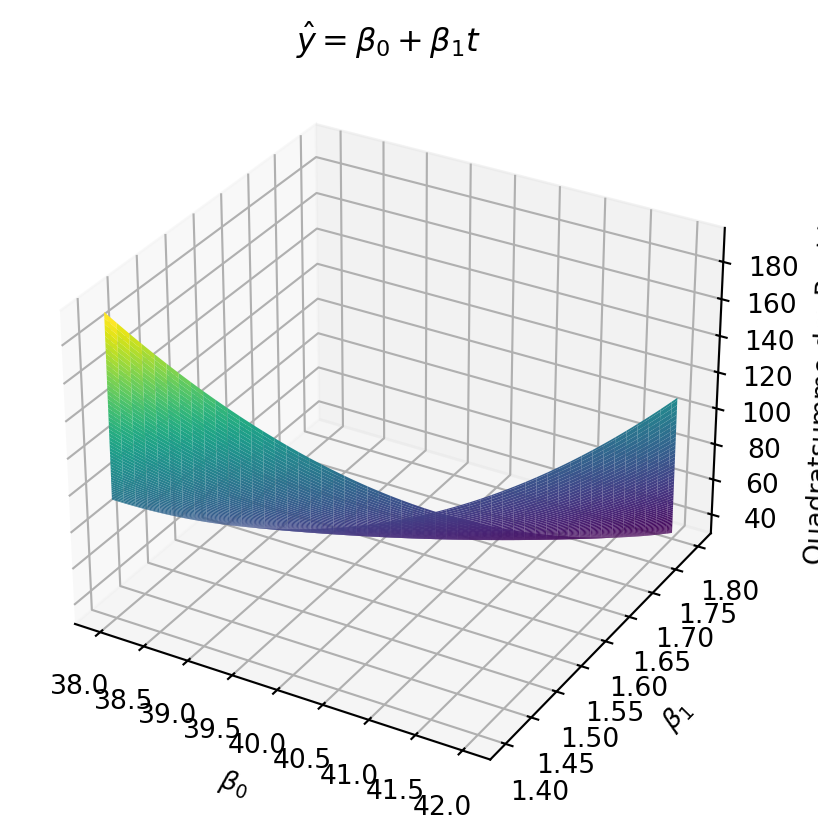

In [7]:
# Visualize the residual sum of squares for a range of parameters

beta_0_values = np.linspace(38, 42, 100)
beta_1_values = np.linspace(1.4, 1.8, 100)

RSS = np.zeros((len(beta_0_values), len(beta_1_values)))

for i in range(len(beta_0_values)):
    for j in range(len(beta_1_values)):
        y_predicted = beta_0_values[i] + beta_1_values[j] * dt["time"]
        RSS[i, j] = np.sum((dt["y"] - y_predicted) ** 2)

# Plot the RSS surface

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta_0_values, beta_1_values, RSS.T, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('Quadratsumme der Residuen')
plt.title(r'$\hat{y} = \beta_0 + \beta_1 t$')

Anstatt die Ableitungen der Funktion zu berechnen, werden wir die optimalen Werte von $\beta_0$ und $\beta_1$ 
mit `Gurobi` berechnen.

Wir suchen den Minimum der Funktion:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t=1}^{T} r^2_t
\end{align*}
$$

Die Residuen $r_t$ sind:

$$
\begin{align*}
r_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,2,\ldots, T\\
\end{align*}
$$

:::{.callout-note}
## Unbeschränkte Variablen

Bei der Umsetzung in `Gurobi` müssen wir darauf achten, dass sowohl die Residuen als auch die Koeffizienten negative Werte annehmen können. Die Voreinstellung in `Gurobi` ist, dass die Variablen nichtnegativ sind. Deswegen müssen wir die untere Schranken dieser Variable  auf $-\infty$ (`lb=-GRB.INFINITY`) setzen.

:::
:::{.callout-note}
## Gurobi Matrixvariablen

Das Program werden wir mit `Gurobi` Matrixvariablen umsetzen. Diese erleichtern 
die Implementierung, denn wir können Schleifen durch Matrixoperationen ersetzen. Beachten Sie, dass
wir in dem Code unten die Variablen durch `m.addMVar` statt `m.addVars` erstellen.

:::



In [8]:
# Gurobi model for least squares

m = gp.Model("Kleinste Quadrate")

# Hier definieren wir die Variablen für die Koeffizienten beta_0 und beta_1.
beta_0 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_0")
beta_1 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_1")

# Hier definieren wir die Variablen für die Residuen. Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (dt.shape[0]).
residuals = m.addMVar(dt.shape[0], lb=-GRB.INFINITY, name="r")

# Einschränkungen für die Residuen

m.addConstr(dt["y"].values - (beta_0 + beta_1 * dt["time"].values) == residuals, name="Residuals")

# Die Zielfunktion ist die Summe der quadrierten Residuen und wir suchen den Minimalwert.

m.setObjective((residuals**2).sum(), GRB.MINIMIZE)

m.write("model-ols.lp")

with open("model-ols.lp", "r") as f:
    print(f.read())


Restricted license - for non-production use only - expires 2027-11-29


\ Model Kleinste Quadrate
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 [ 2 r[0] ^2 + 2 r[1] ^2 + 2 r[2] ^2 + 2 r[3] ^2 + 2 r[4] ^2 + 2 r[5] ^2
   + 2 r[6] ^2 + 2 r[7] ^2 + 2 r[8] ^2 + 2 r[9] ^2 ] / 2 
Subject To
 Residuals[0]: - beta_0[0] - beta_1[0] - r[0] = -45.02810469193533
 Residuals[1]: - beta_0[0] - 2 beta_1[0] - r[1] = -43.80031441673444
 Residuals[2]: - beta_0[0] - 3 beta_1[0] - r[2] = -46.45747596821148
 Residuals[3]: - beta_0[0] - 4 beta_1[0] - r[3] = -50.48178639840292
 Residuals[4]: - beta_0[0] - 5 beta_1[0] - r[4] = -51.23511598029994
 Residuals[5]: - beta_0[0] - 6 beta_1[0] - r[5] = -47.04544424024718
 Residuals[6]: - beta_0[0] - 7 beta_1[0] - r[6] = -52.40017683505118
 Residuals[7]: - beta_0[0] - 8 beta_1[0] - r[7] = -51.69728558340461
 Residuals[8]: - beta_0[0] - 9 beta_1[0] - r[8] = -53.29356229641289
 Residuals[9]: - beta_0[0] - 10 beta_1[0] - r[9] = -55.82119700387675
Bounds
 beta_0[0] free
 beta_1[0] free
 r[0] free
 r[1]

In [9]:
m.optimize()

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64 - "Ubuntu 24.04.4 LTS")


CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 10 rows, 12 columns and 30 nonzeros (Min)


Model fingerprint: 0x9aba8ede


Model has 0 linear objective coefficients


Model has 10 quadratic objective terms


Coefficient statistics:


  Matrix range     [1e+00, 1e+01]


  Objective range  [0e+00, 0e+00]


  QObjective range [2e+00, 2e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+01, 6e+01]


Presolve time: 0.00s


Presolved: 10 rows, 12 columns, 30 nonzeros


Presolved model has 10 quadratic objective terms


Ordering time: 0.00s


Barrier statistics:


 Free vars  : 12


 AA' NZ     : 4.500e+01


 Factor NZ  : 5.500e+01


 Factor Ops : 3.850e+02 (less than 1 second per iteration)


 Threads    : 1


                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.95366928e+01 -4.95366928e+01  7.11e-15 4.06e+00  0.00e+00     0s


   1   4.57239907e+01 -4.05880220e+01  6.66e-07 3.69e+00  0.00e+00     0s


   2   3.86563906e+01 -2.22638913e+01  1.59e-06 2.87e+00  0.00e+00     0s


   3   3.43016404e+01 -8.96298501e+00  1.45e-06 2.22e+00  0.00e+00     0s


   4   2.88713311e+01  1.47947103e+01  1.46e-06 8.79e-01  0.00e+00     0s


   5   2.79028540e+01  2.52615609e+01  2.82e-06 1.86e-01  0.00e+00     0s


   6   2.78574204e+01  2.78574180e+01  3.56e-07 1.86e-07  0.00e+00     0s


   7   2.78574205e+01  2.78574205e+01  8.95e-13 1.86e-13  0.00e+00     0s


Barrier solved model in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective 2.78574205e+01


In [10]:
# Optimal parameters
beta_0.X, beta_1.X

(array([43.34754255]), array([1.15972796]))

In [11]:
# # Calculate the predicted values and residuals

# dt["y_predicted_OLS"] = ...
# dt["residuals_OLS"] = ...

In [12]:
# # Plot the data and the predictions

# plt.plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
# plt.plot(dt["time"], dt["y_predicted_OLS"], 'r-', label='OLS predictions')
# plt.xlabel('Monat')
# plt.ylabel('Backsteine')
# plt.title('Nachfrage')
# plt.legend()

In [13]:
# Compare with OLS

from sklearn.linear_model import LinearRegression

X = dt["time"].values.reshape(-1, 1)  # Sklearn erwartet eine Matrix

ols = LinearRegression()
ols.fit(X, dt["y"].values)

ols.coef_, ols.intercept_


(array([1.15972796]), np.float64(43.34754255442168))

In [14]:
# Berechnen Sie die Residuenquadratsumme für die naive Schätzung und für die OLS-Schätzung



## Kleinste absolute Abweichungen

$$
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |y_t - (\beta_0 + \beta_1 t )|
$$


Text(0.5, 1.0, '$\\hat{y} = \\beta_0$')

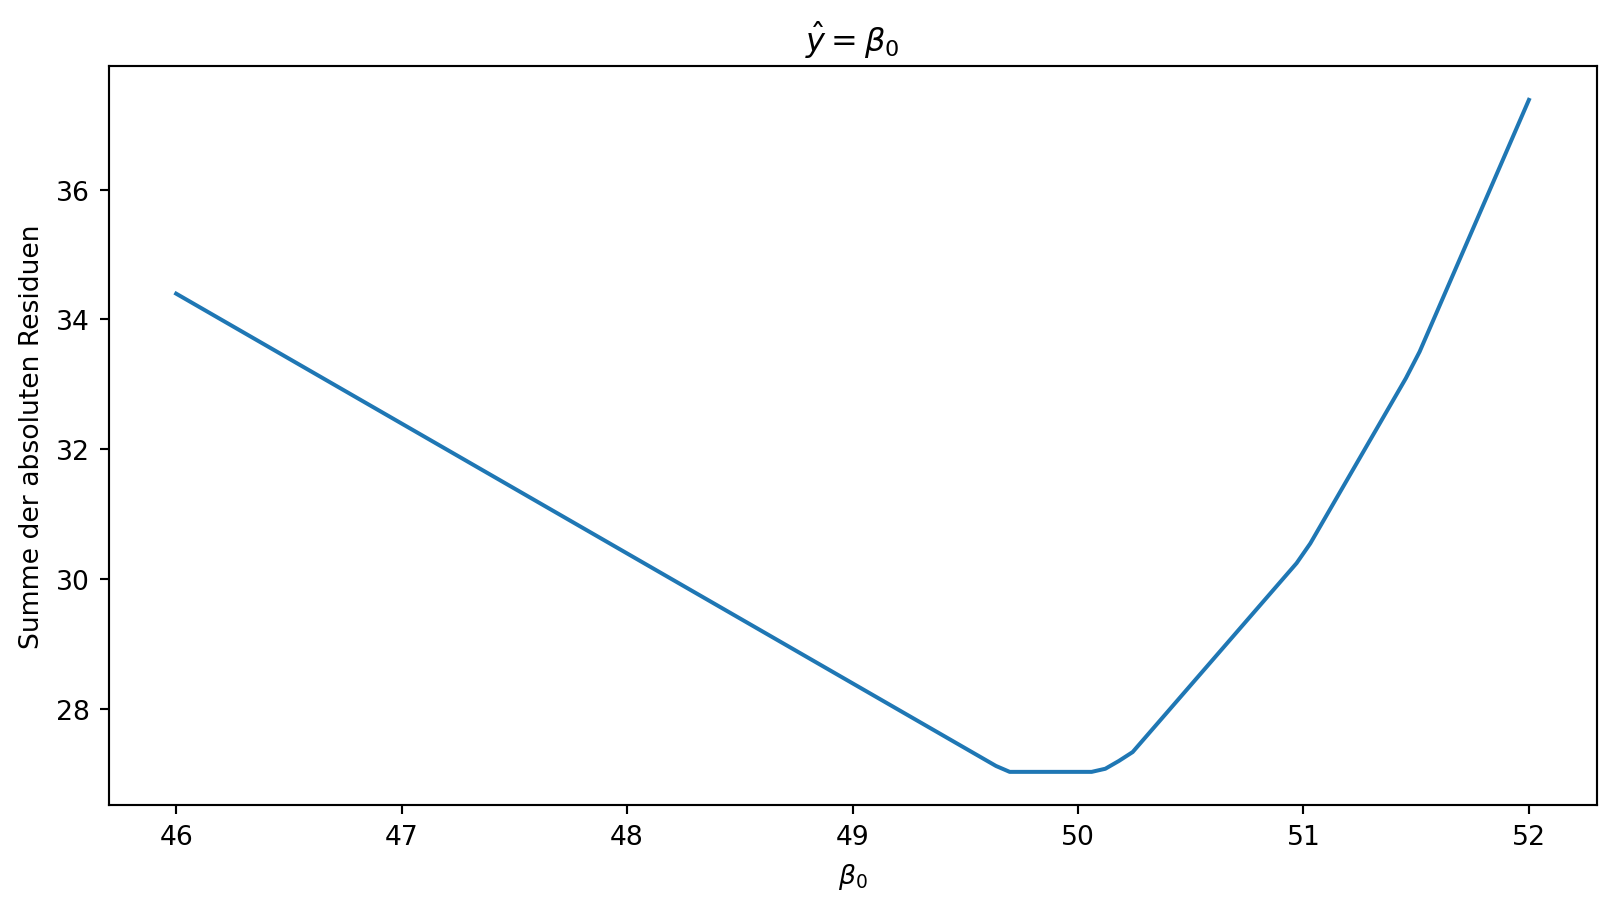

In [15]:
# Compute the sum of absolute residuals for a range of values for beta_0

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted

# Calculate the sum of absolute residuals
sum_abs_residuals = np.sum(np.abs(residuals), axis=1)

# Plot the sum of absolute residuals
plt.figure(figsize=(10, 5))
plt.plot(beta_0_values, sum_abs_residuals)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der absoluten Residuen')
plt.title(r'$\hat{y} = \beta_0$')

Auf den ersten Blick sieht es so aus, dass diese Aufgabe eher nicht in unsere lineare Welt passt, denn wir haben hier die Betragsfunktion und diese ist nicht linear. Es stellt sich jedoch heraus, dass wir diese Aufgabe mit den Methoden der linearen Optimierung lösen können. Die Residuen $r_t$ sind wie zuvor definiert:

$$
r_t = y_t - (\beta_0 + \beta_1 t)
$$

und wir minimieren die Summe der Beträge der Residuen:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |r_t|
\end{align*}
$$

Wir können die Betragsfunktion mit Hilfe von zwei Variablen $r^{+}_t$ und $r^{-}_t$ linearisieren. Wir können jede beliebige Zahl als Differenz von zwei nicht-negativen Zahlen darstellen:

$$
\begin{align*}
5 & = 5 - 0 \\
-3 & = 0 - 3 \\
r_t & = r^{+}_t - r^{-}_t \\
\end{align*}
$$

Der Betrag einer Zahl $x$ ist dann einfach die Summe der beiden nicht-negativen Zahlen:

$$
\begin{align*}
|5| & = 5 + 0 \\
|-3| & = 0 + 3 \\
|r_t| & = r^{+}_t + r^{-}_t \\
\end{align*}
$$

Jetzt können wir die Beträge der Residuen $r_t$ durch die Summe der negativen und positiven Residuen $r^{+}_t$ und $r^{-}_t$ ersetzen. Dann wird die Zielfunktion:

$$
\begin{align*}
\min \sum_{t = 1}^{T} |r_t| & = \min \sum_{t = 1}^{T} (r^{+}_t + r^{-}_t) \\
\end{align*}
$$

Die Einschränkungen sind dann:

$$
\begin{align*}
r_t = r^{+}_t - r^{-}_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,\ldots,T\\
r^{+}_t & \geq 0 \\
r^{-}_t & \geq 0 \\
\end{align*}
$$


Bevor wir die Aufgabe mit `Gurobi` umsetzen, möchten wir die Prognose der Nachfrage in Matrixform darstellen, denn diese erleichtert erheblich die Implementierung, insbesondere wenn wir mehr als zwei Koeffizienten haben.

Bei gegebenen Koeffizienten $\beta_0$ und $\beta_1$ können wir die Nachfrage für alle Monate $t$ aufschreiben als:

$$
\begin{align*}
t = 1 \rightarrow & \quad \hat{y}_1 = \beta_0 + \beta_1 \cdot 1 \\
t = 2 \rightarrow & \quad \hat{y}_2 = \beta_0 + \beta_1 \cdot 2 \\
\vdots \\
t = T \rightarrow & \quad \hat{y}_T = \beta_0 + \beta_1 \cdot T \\
\end{align*}
$$

Das können wir in Matrixform schreiben:

$$
\begin{align*}
\hat{y} = \begin{pmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_T \end{pmatrix} & = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} \beta_0 + \begin{pmatrix} 1 \\ 2 \\ \vdots \\ T \end{pmatrix} \beta_1 \\
\end{align*}
$$

$$
\begin{align*}
\hat{y} = \underbrace{\begin{pmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_T \end{pmatrix}}_{T \times 1}  & = \underbrace{\begin{pmatrix} 1 & 1  \\ 1 & 2 \\ \vdots & \vdots \\ 1 & T \end{pmatrix}}_{T \times 2} \underbrace{\begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}}_{2 \times 1} \\ 
\end{align*}
$$

oder in noch kompakterer Form:

$$
\begin{align*}
\hat{y} & = X \beta \\
\end{align*}
$$

Die Matrix $X$ nennen wir die Designmatrix.



In [16]:
# Um die X-Matrix zu erstellen, verwenden wir die Funktiob dmatrix aus patsy
from patsy import dmatrix

X = dmatrix("1 + time", data = dt)
X

DesignMatrix with shape (10, 2)
  Intercept  time
          1     1
          1     2
          1     3
          1     4
          1     5
          1     6
          1     7
          1     8
          1     9
          1    10
  Terms:
    'Intercept' (column 0)
    'time' (column 1)

In [17]:
# Beispiel: für beta_0 = 40 und beta_1 = 0.2 sind die Prognosen

X @ np.array([40, 0.2])

array([40.2, 40.4, 40.6, 40.8, 41. , 41.2, 41.4, 41.6, 41.8, 42. ])

In [18]:
mlad = gp.Model("LAD Regression")

# Wir definieren die Variablen (r+)

# Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (Zeilen in X, also X.shape[0])

# Variablen

# Die Anzahl der Parameter ist gleich der Anzahl der Spalten in X (also X.shape[1])

# beta = mlad.addMVar(..., ..., name="beta")

# Residuen

# Die Einschränkungen

# Die Zielfunktion (Objective Function)

mlad.write("model-lad.lp")
with open("model-lad.lp", "r") as f:
    print(f.read())

mlad.optimize()


\ Model LAD Regression
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 
Subject To
Bounds
End

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64 - "Ubuntu 24.04.4 LTS")


CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 0 rows, 0 columns and 0 nonzeros (Min)


Model fingerprint: 0xf9715da1


Model has 0 linear objective coefficients


Coefficient statistics:


  Matrix range     [0e+00, 0e+00]


  Objective range  [0e+00, 0e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [0e+00, 0e+00]


Presolve time: 0.00s


Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s


Solved in 0 iterations and 0.00 seconds (0.00 work units)


Optimal objective  0.000000000e+00


In [19]:
# dt["y_predicted_LAD"] = ...
# dt["residuals_LAD"] = ...

In [20]:
# # Plot the data and the trend line

# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
# ax.plot(dt["time"], dt["y_predicted_LAD"], 'r-', label='LAD Schätzungen')
# ax.plot(dt["time"], dt["y_predicted_naive"], 'g-', label='Naive Schätzungen')
# ax.plot(dt["time"], dt["y_predicted_OLS"], 'b-', label='OLS Schätzungen')

# ax.set_title('Nachfrage')
# ax.set_xlabel('Time')
# ax.legend()